# IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, tqdm
import seaborn as sns
import scipy.io

# About Data

## Li-ion Battery Aging Datasets

This data set has been collected from a custom built battery prognostics testbed at the NASA Ames Prognostics Center of Excellence (PCoE). Li-ion batteries were run through 3 different operational profiles (charge, discharge and Electrochemical Impedance Spectroscopy) at different temperatures. Discharges were carried out at different current load levels until the battery voltage fell to preset voltage thresholds. Some of these thresholds were lower than that recommended by the OEM (2.7 V) in order to induce deep discharge aging effects. Repeated charge and discharge cycles result in accelerated aging of the batteries. The experiments were stopped when the batteries reached the end-of-life (EOL) criteria of 30% fade in rated capacity (from 2 Ah to 1.4 Ah).



**Data Acquisition:**

The testbed comprises:

* Commercially available Li-ion 18650 sized rechargeable batteries,
* Programmable 4-channel DC electronic load,
* Programmable 4-channel DC power supply,
* Voltmeter, ammeter and thermocouple sensor suite,
* Custom EIS equipment,
* Environmental chamber to impose various operational conditions,
* PXI chassis based DAQ and experiment control, and



MATLAB based experiment control, data acquisition and prognostics algorithm evaluation setup (appx. data acquisition rate is 10Hz).



**Parameter Description:**

Data Structure:

- cycle: top level structure array containing the charge, discharge and impedance operations

- type: operation type, can be charge, discharge or impedance

- ambient_temperature: ambient temperature (degree C)

- time: the date and time of the start of the cycle, in MATLAB date vector format

- data: data structure containing the measurements


for charge the fields are:

- Voltage_measured: Battery terminal voltage (Volts)

- Current_measured: Battery output current (Amps)

- Temperature_measured: Battery temperature (degree C)

- Current_charge: Current measured at charger (Amps)

- Voltage_charge: Voltage measured at charger (Volts)

- Time: Time vector for the cycle (secs)


for discharge the fields are:

- Voltage_measured: Battery terminal voltage (Volts)

- Current_measured: Battery output current (Amps)

- Temperature_measured: Battery temperature (degree C)

- Current_charge: Current measured at load (Amps)

- Voltage_charge: Voltage measured at load (Volts)

- Time: Time vector for the cycle (secs)

- Capacity: Battery capacity (Ahr) for discharge till 2.7V


for impedance the fields are:

- Sense_current: Current in sense branch (Amps)

- Battery_current: Current in battery branch (Amps)

- Current_ratio: Ratio of the above currents

- Battery_impedance: Battery impedance (Ohms) computed from raw data

- Rectified_impedance: Calibrated and smoothed battery impedance (Ohms)

- Re: Estimated electrolyte resistance (Ohms)

- Rct: Estimated charge transfer resistance (Ohms)

# Transforming MATLAB files into Machine Learning Reading CSV files

The Li-ion Battery Dataset obtained contains data in .mat format which isnt suited well for training Machine Learning models. Hence, objective of this section is to explore the original raw dataset and transform it into a Machine Learning ready dataset in a significantly better format.

In [2]:
# Helper functions
def load_filelist():
    
    FILELIST = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:

            #filepath = filename
            FILELIST.append(os.path.join(dirname, filename))
    return FILELIST
            
            
def filter_matfiles_list(filelist):
    filelist = [filepath for filepath in filelist if filepath.endswith('.mat')]
    filelist = [filepath for filepath in filelist if "BatteryAgingARC_25_26_27_28_P1" not in filepath] # removing duplicates
    return filelist


def loadmat(filepath):
    return scipy.io.loadmat(filepath, simplify_cells=True)

In [3]:
FILELIST = filter_matfiles_list(load_filelist())

## Generic Dataset Informations
Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses.

- Charge profile:
    - The charge profile for all battery tests seems to be identifical.
    - Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. 

- Discharge:
    - Discharge profiles were different from battery to battery.
    - Discharge was carried out at a constant current (CC) level of 1-4 A until the battery voltage fell to values such 2.7V, 2.5V, 2.2V and 2.5V.

- Impedance:
    - Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz.

The experiments were stopped when the batteries reached a given end-of-life (EOL) criteria: for example 30% fade in rated capacity (from 2Ahr to 1.4Ahr). Other stopping criteria were used such as 20% fade in rated capacity. Note that for batteries 49,50,51,52, the experiments were not stop due to battery EOL but because the software has crashed.

## Tasks

This dataset can be used for the prediction of both:
- remaining charge (for a given discharge cycle) and,
- remaining useful life (RUL).

## Structure of .mat files
- **dictionary** (loaded mat file)
    - **dictionary** (e.g. B0005)
        - **list (cycle)** -> one test per element in the list
            - element of the list = dict = all data for one test of that battery
                - **type**:  operation  type, can be charge, discharge or impedance
                - **ambient_temperature**:  ambient temperature (degree C)
                - **time**:  the date and time of the start of the cycle, in MATLAB  date vector format
                - **data (dict)**:  data structure containing the measurements
                    - data fields with key being measured variable, values the actual records (see below)
                    
                    
*    for charge the fields are:
    *     Voltage_measured: 	Battery terminal voltage (Volts)
    *     Current_measured:	Battery output current (Amps)
    *     Temperature_measured: 	Battery temperature (degree C)
    *     Current_charge:		Current measured at charger (Amps)
    *     Voltage_charge:		Voltage measured at charger (Volts)
    *     Time:			Time vector for the cycle (secs)
*    for discharge the fields are:
    *     Voltage_measured: 	Battery terminal voltage (Volts)
    *     Current_measured:	Battery output current (Amps)
    *     Temperature_measured: 	Battery temperature (degree C)
    *     Current_load:		Current measured at load (Amps)
    *     Voltage_load:		Voltage measured at load (Volts)
    *     Time:			Time vector for the cycle (secs)
    *     Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
*    for impedance the fields are:
    *     Sense_current:		Current in sense branch (Amps)
    *     Battery_current:	Current in battery branch (Amps)
    *     Current_ratio:		Ratio of the above currents 
    *     Battery_impedance:	Battery impedance (Ohms) computed from raw data
    *     Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
    *     Re:			Estimated electrolyte resistance (Ohms)
    *     Rct:			Estimated charge transfer resistance (Ohms)

In [4]:
mat = loadmat("../input/d/zlayuz/nasa-battery-dataset/NASA-BATTERY-DATASET/BatteryAgingARC-FY08Q4/B0005.mat/B0005.mat")

In [5]:
df = pd.DataFrame(data=mat['B0005']['cycle'][0]['data'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      789 non-null    float64
 1   Current_measured      789 non-null    float64
 2   Temperature_measured  789 non-null    float64
 3   Current_charge        789 non-null    float64
 4   Voltage_charge        789 non-null    float64
 5   Time                  789 non-null    float64
dtypes: float64(6)
memory usage: 37.1 KB


In [7]:
import matplotlib.pyplot as plt

def plot_test_data(df, profile="charge"):
    
    if profile=='charge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_charge, 'b', label='Voltage_charge')
        plt.plot(df.Time, df.Current_charge, 'r', label='Current_charge')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='discharge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_load, 'b', label='Voltage_load')
        plt.plot(df.Time, df.Current_load, 'r', label='Current_load')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='impedance':
        pass
    else:
        print('No cycle recognized')

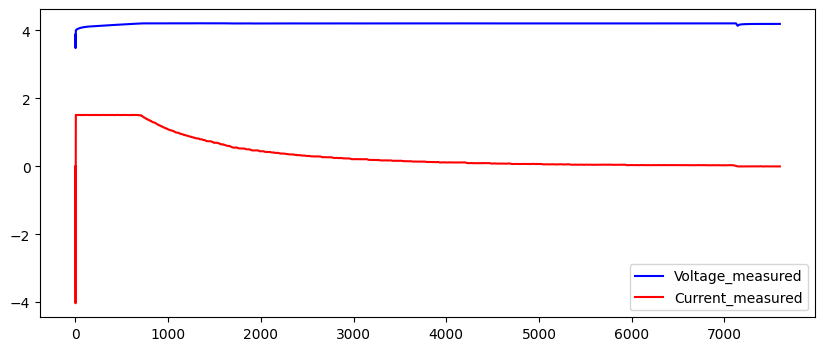

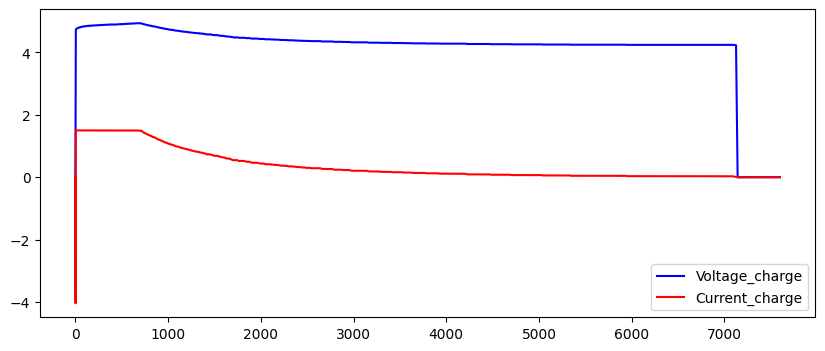

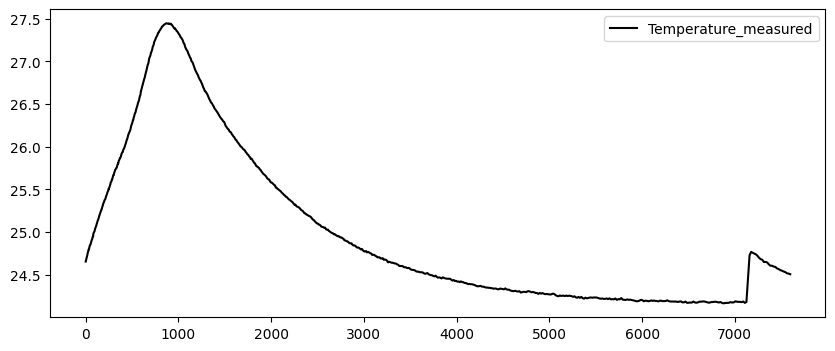

In [8]:
plot_test_data(df)

In [9]:
df = pd.DataFrame(data=mat['B0005']['cycle'][1]['data'])
df.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487


In [10]:
def process_data_dict(data_dict):
    """ Creates two dictionaries:
    - ndict: new dictionary with the test data to build a corresponding dataframe
    - metadata_dict: anything that doesn't fit in ndict ('Capacity' is just a float)
    """
    
    ndict = {}
    metadata_dict = {}
    for k, v in data_dict.items():
        if k not in ['Capacity', 'Re', 'Rct']:
            ndict[k]=v
        elif k == 'Capacity':
            metadata_dict[k]=v
        elif k == 'Re':
            metadata_dict[k]=v
        elif k == 'Rct':
            metadata_dict[k]=v
        else:
            print("c'est la merde")
    
    return ndict, metadata_dict


def fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct):
    tmp = pd.DataFrame(data=[test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct])
    tmp = tmp.transpose()
    tmp.columns = metadata.columns
    metadata = pd.concat((metadata, tmp), axis=0)
    return metadata


def extract_more_metadata(metadata_dict):
    
    if 'Capacity' in metadata_dict.keys():
        capacity = metadata_dict['Capacity']
    else:
        capacity = np.nan
        
    if 'Re' in metadata_dict.keys():
        re = metadata_dict['Re']
    else:
        re = np.nan
        
    if 'Rct' in metadata_dict.keys():
        rct = metadata_dict['Rct']
    else:
        rct = np.nan
    
    return capacity, re, rct

The metadata.csv file is used to store information about various files, indicating whether they represent charging, discharging, or impedance data. For example, file 0001.csv contains charging data for battery number 25.

In [11]:
metadata = pd.DataFrame(data=None, columns=['type', 'start_time', 'ambient_temperature', 'battery_id', 'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct'])
battery_list = [item.split('/')[-1].split('.')[0] for item in FILELIST]

In [12]:
# We create a tmp directory in which we will save all CSV files
CWD = os.getcwd()
os.listdir(CWD)
directory = "tmp"
path = os.path.join(CWD, directory)
if not os.path.exists(path):
    os.mkdir(path)

In [13]:
os.listdir(CWD) # we check that tmp exists now

['.virtual_documents', 'tmp']

## Converting to CSV

In [ ]:
uid = 0
# counter = 0
for battery_name, mat_filepath in zip(battery_list, FILELIST):
    # counter +=1
    
    mat_data = scipy.io.loadmat(mat_filepath, simplify_cells=True)
    print(mat_filepath[-10:],"-->", battery_name)
    test_list = mat_data[battery_name]['cycle']
    
    for test_id in range(len(test_list)):
        
        uid += 1
        filename = str(uid).zfill(5)+'.csv'
        filepath = './tmp/' + filename

        # Extract the specific test data and save it as CSV! 
        ndict, metadata_dict = process_data_dict(test_list[test_id]['data'])
        test_df = pd.DataFrame.from_dict(ndict, orient='index')
        test_df = test_df.transpose()

        test_df.to_csv(filepath, index=False)
                
        # Add test information to the metadata
        test_type = test_list[test_id]['type']
        test_start_time = test_list[test_id]['time']
        test_temperature = test_list[test_id]['ambient_temperature']
        
        capacity, re, rct = extract_more_metadata(metadata_dict)
        metadata = fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct)
        

/B0047.mat --> B0047
/B0045.mat --> B0045
/B0048.mat --> B0048
/B0046.mat --> B0046
/B0043.mat --> B0043
/B0032.mat --> B0032
/B0039.mat --> B0039
/B0040.mat --> B0040
/B0029.mat --> B0029
/B0028.mat --> B0028
/B0042.mat --> B0042
/B0034.mat --> B0034
/B0038.mat --> B0038
/B0033.mat --> B0033
/B0030.mat --> B0030
/B0041.mat --> B0041
/B0027.mat --> B0027
/B0044.mat --> B0044
/B0036.mat --> B0036
/B0025.mat --> B0025
/B0026.mat --> B0026
/B0031.mat --> B0031
/B0049.mat --> B0049
/B0050.mat --> B0050
/B0052.mat --> B0052
/B0051.mat --> B0051
/B0006.mat --> B0006
/B0005.mat --> B0005
/B0007.mat --> B0007
/B0018.mat --> B0018
/B0053.mat --> B0053
/B0054.mat --> B0054
/B0056.mat --> B0056
/B0055.mat --> B0055


In [ ]:
metadata.to_csv('metadata.csv', index=False)

In [ ]:
metadata.info()

# Preparing DATA for Analysis 

## START TIME FORMATTNG 

### Convert start_time column into datetime format

In [ ]:
# Helper functions
def load_filelist():
    
    FILELIST = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:

            #filepath = filename
            FILELIST.append(os.path.join(dirname, filename))
    return FILELIST
            
            
def filter_matfiles_list(filelist):
    filelist = [filepath for filepath in filelist if filepath.endswith('.mat')]
    filelist = [filepath for filepath in filelist if "BatteryAgingARC_25_26_27_28_P1" not in filepath] # removing duplicates
    return filelist


def loadmat(filepath):
    return scipy.io.loadmat(filepath, simplify_cells=True)

In [ ]:
FILELIST = filter_matfiles_list(load_filelist())

In [ ]:
def process_data_dict(data_dict):
    """ Creates two dictionaries:
    - ndict: new dictionary with the test data to build a corresponding dataframe
    - metadata_dict: anything that doesn't fit in ndict ('Capacity' is just a float)
    """
    
    ndict = {}
    metadata_dict = {}
    for k, v in data_dict.items():
        if k not in ['Capacity', 'Re', 'Rct']:
            ndict[k]=v
        elif k == 'Capacity':
            metadata_dict[k]=v
        elif k == 'Re':
            metadata_dict[k]=v
        elif k == 'Rct':
            metadata_dict[k]=v
        else:
            print("c'est la merde")
    
    return ndict, metadata_dict


def fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct):
    tmp = pd.DataFrame(data=[test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct])
    tmp = tmp.transpose()
    tmp.columns = metadata.columns
    metadata = pd.concat((metadata, tmp), axis=0)
    return metadata

def extract_more_metadata(metadata_dict):
    
    if 'Capacity' in metadata_dict.keys():
        capacity = metadata_dict['Capacity']
    else:
        capacity = np.nan
        
    if 'Re' in metadata_dict.keys():
        re = metadata_dict['Re']
    else:
        re = np.nan
        
    if 'Rct' in metadata_dict.keys():
        rct = metadata_dict['Rct']
    else:
        rct = np.nan
    
    return capacity, re, rct

In [ ]:
metadata = pd.DataFrame(data=None, columns=['type', 'start_time', 'ambient_temperature', 'battery_id', 'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct'])
battery_list = [item.split('/')[-1].split('.')[0] for item in FILELIST]

In [ ]:
# We create a tmp directory in which we will save all CSV files
CWD = os.getcwd()
os.listdir(CWD)
directory = "tmp"
path = os.path.join(CWD, directory)
if not os.path.exists(path):
    os.mkdir(path)

In [ ]:
os.listdir(CWD) # we check that tmp exists now

In [ ]:
uid = 0
# counter = 0
for battery_name, mat_filepath in zip(battery_list, FILELIST):
    # counter +=1
    
    mat_data = scipy.io.loadmat(mat_filepath, simplify_cells=True)
    #print(mat_filepath[-10:],"-->", battery_name)
    test_list = mat_data[battery_name]['cycle']
    
    for test_id in range(len(test_list)):
        
        uid += 1
        filename = str(uid).zfill(5)+'.csv'
        #filepath = './tmp/' + filename

        # Extract the specific test data and save it as CSV! 
        ndict, metadata_dict = process_data_dict(test_list[test_id]['data'])
        #test_df = pd.DataFrame.from_dict(ndict, orient='index')
        #test_df = test_df.transpose()

        #test_df.to_csv(filepath, index=False)
                
        # Add test information to the metadata
        test_type = test_list[test_id]['type']
        test_start_time = test_list[test_id]['time']
        test_temperature = test_list[test_id]['ambient_temperature']
        
        capacity, re, rct = extract_more_metadata(metadata_dict)
        metadata = fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct)

In [ ]:
# Reset the index of metadata dataframe
metadata = metadata.reset_index(drop=True)
print(metadata.shape)
metadata.head()

In [ ]:
from datetime import datetime

# Function to convert list to datetime
def convert_list_to_datetime(lst):
    y = int(lst[0])
    m = int(lst[1])
    d = int(lst[2])
    H = int(lst[3])
    M = int(lst[4])
    S = int(lst[5])  # Seconds rounded to integer
    return datetime(y, m, d, H, M, S)

# Apply function to entire column
metadata_1 = metadata.copy()
metadata_1['start_time'] = metadata_1['start_time'].apply(convert_list_to_datetime)

# Test
print(metadata_1['start_time'][0])  # Should print datetime object
print(metadata_1['start_time'][0].year)  # Should correctly give year

In [ ]:
# Example usage of start_time column
metadata_1['start_time'][0].year # year, month, day, hour, minute, second

In [ ]:
metadata_1.to_csv('metadata.csv', index=False)

In [ ]:
metadata_1.info()

# EDA

In [ ]:
metadata_1.head()

In [ ]:
# We will use the matadata csv with corrected start_time format
# metadata_df = pd.read_csv("/kaggle/input/nasa-dataset-start-time-formatting/metadata.csv")
# metadata_df['start_time'] = pd.to_datetime(metadata_df['start_time'])
metadata_df=metadata_1
print(metadata_df.shape)
metadata_df.head()

In [ ]:
# Replace [] with np.nan in Capacity column
metadata_df.loc[metadata_df["Capacity"]=="[]", "Capacity"] = np.nan
metadata_df[metadata_df["Capacity"]=="[]"]["Capacity"]

In [ ]:
battery_group = {"1": ["B0025", "B0026", "B0027", "B0028"],
                "2b": ["B0029", "B0030", "B0031", "B0032"],
                "2c": ["B0033", "B0034", "B0036"],
                "2d": ["B0038", "B0039", "B0040"],
                "2e": ["B0041", "B0042", "B0043", "B0044"],
                "3": ["B0045", "B0046", "B0047", "B0048"],
                "4": ["B0049", "B0050", "B0051", "B0052"],
                "5": ["B0053", "B0054", "B0055", "B0056"],
                "6": ["B0005", "B0006", "B0007", "B0018"]}

In [ ]:
# Create box plots for each battery in each group
def plot_capacity_boxplot(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    capacity = []
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        clist = df[df["Capacity"].notna()]["Capacity"].astype(float).tolist()
        capacity.append(clist)
        print(len(clist))
        
    ax.boxplot(capacity)
    plt.legend()
    plt.ylim(-0.4,2.9)
    plt.xticks(range(1,len(cells[group]) + 1), cells[group])
    #plt.xlabel("Battery")
    plt.ylabel("Capacity [Ah]")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [ ]:
def plot_capacity_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        df["Capacity"] = df["Capacity"].astype(float)
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Capacity"], marker='.', label=cell)
        
    plt.axhline(70.0, color='k', linestyle='--')    
    plt.legend()
    plt.ylim(0,2.49)
    #plt.xlim(0,30)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("Capacity [Ah]")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [ ]:
def plot_SOH_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        df["Capacity"] = df["Capacity"].astype(float)/2.0 * 100.0
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Capacity"], marker='.', label=cell)
        
    plt.axhline(70.0, color='k', linestyle='--')    
    plt.legend()
    plt.ylim(0,119)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("SOH %")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [ ]:
GROUP = "6"
plot_capacity_vs_cycle(battery_group, GROUP)
plot_capacity_boxplot(battery_group, GROUP)
plot_SOH_vs_cycle(battery_group, GROUP)

In [ ]:
# Label each battery with their group
metadata_df["Group"] = ""
for key in list(battery_group.keys()):
    for cell in battery_group[key]:
        metadata_df.loc[metadata_df["battery_id"]==cell, "Group"] = key

print(metadata_df.shape)
metadata_df.head()

In [ ]:
#battery_ids = metadata_df["battery_id"].value_counts().index
# Manually arranged
battery_ids = ['B0007', 'B0005', 'B0006', 'B0018', 'B0033', 'B0036', 'B0034', 'B0044',
               'B0043', 'B0042', 'B0041', 'B0054', 'B0056', 'B0055', 'B0053', 'B0047', 
               'B0048', 'B0045', 'B0046', 'B0040', 'B0039', 'B0038', 'B0030', 'B0029',
               'B0031', 'B0032', 'B0026', 'B0025', 'B0028', 'B0027', 'B0049', 'B0052',
               'B0051', 'B0050']

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
sns.countplot(data=metadata_df[metadata_df["type"]=="discharge"], x="battery_id", order=battery_ids, dodge=False, hue=metadata_df["Group"])
plt.tick_params(axis='x', rotation=90)
plt.ylabel("Number of cycles")
plt.xlabel("Battery ID")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [5,1,3,2,4,0,6,8,7] # Quite confusing

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right") 

plt.title('Total Cycles per Battery')
plt.show()

In [ ]:
# Plot voltage vs time during discharging cycles
BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    # Add start_time and Time (seconds)
    #start_time = metadata_df[metadata_df["filename"]==filename]['start_time']
    #battery_data['Date'] = start_time.iloc[0] + pd.to_timedelta(battery_data['Time'], unit='s')   
    ax.plot(battery_data["Time"], battery_data["Voltage_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(2.3,4.5)
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Voltage [V]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Voltage on Discharge")
plt.show()

In [ ]:
# Plot temperature vs time during discharging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Temperature_measured"], marker='.', label=cycle)
    cycle += 1
       
plt.ylim(20, 45) 
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [deg C]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Temperature on Discharge")
plt.show()

In [ ]:

# Plot current vs time during discharging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Current_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(-2.5,1) 
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Current [A]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Current on Discharge")
plt.show()

In [ ]:
# Plot voltage vs time during charging cycles 
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}") 
    ax.plot(battery_data["Time"], battery_data["Voltage_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(3,4.5)    
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Voltage [V]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Voltage on Charge")
plt.show()

In [ ]:
# Plot temperature vs time during Charging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Temperature_measured"], marker='.', label=cycle)
    cycle += 1
       
plt.ylim(20, 45)        
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [deg C]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Temperature on Charge")
plt.show()

In [ ]:
# Plot Current vs time during charging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()
for filename in filenames:
    battery_data = pd.read_csv(f"/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/{filename}")  
    ax.plot(battery_data["Time"], battery_data["Current_measured"], marker='.', label=cycle)
    cycle += 1
    
plt.ylim(-1,2)    
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Current [A]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Current on Charge")
plt.show()

# SOC PREDICTION

In [ ]:
data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00001.csv")
data

**The Discharging Parameters Over Time **

In [ ]:
df = pd.DataFrame(data)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
columns = data.columns

# Plot each parameter against time
sns.lineplot(x='Time', y=columns[0], data=df, ax=axes[0, 0])
sns.lineplot(x='Time', y=columns[1], data=df, ax=axes[0, 1])
sns.lineplot(x='Time', y=columns[2], data=df, ax=axes[0, 2])
sns.lineplot(x='Time', y=columns[3], data=df, ax=axes[1, 0])
sns.lineplot(x='Time', y=columns[4], data=df, ax=axes[1, 1])

# Remove empty subplot
fig.delaxes(axes[1, 2])
plt.suptitle('Discharging Parameters vs. Time')

plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00003.csv")
df = pd.DataFrame (data)
print (df.head())

In [ ]:
data_folder = "/kaggle/input/nasa-battery-dataset/cleaned_dataset"
meta_data = pd.read_csv(os.path.join(data_folder, "metadata.csv"))

In [ ]:

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
columns = data.columns

# Plot each parameter against time
sns.lineplot(x='Time', y=columns[0], data=df, ax=axes[0, 0])
sns.lineplot(x='Time', y=columns[1], data=df, ax=axes[0, 1])
sns.lineplot(x='Time', y=columns[2], data=df, ax=axes[0, 2])
sns.lineplot(x='Time', y=columns[3], data=df, ax=axes[1, 0])
sns.lineplot(x='Time', y=columns[4], data=df, ax=axes[1, 1])

# Remove empty subplot
fig.delaxes(axes[1, 2])
plt.suptitle('Charging Parameters vs. Time')

plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00002.csv")
df_impedance = pd.DataFrame (data)
df_impedance.head()

In [ ]:
df.head()

Now we will group bateries with Id and calcultae the Soc and then train the model and predict new values ****
WE WILL USE LINEAR REGRESSION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
#df['SoC'] = (df['Voltage_measured'] / df['Voltage_measured'].max())
df['SoC'] = (df['Voltage_measured'] / 4.2)*100

print (df.head())
# Split features and target
#this is the target SoC
target = df['SoC']
#these are the features 
features = df[['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time' , 'Current_charge']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
train_x, train_y, test_x, test_y= X_train, y_train, X_test, y_test
print(X_train.head())
y_train.head()

In [ ]:
train_x

In [ ]:
train_x.shape
train_y.shape

## Using BiLSTM model

#### Bidirectional LSTM (BiLSTM)
Bidirectional LSTMs have two LSTM layers: one processes the sequence from start to end (forward), and the other processes it from end to start (backward). This setup allows the model to consider both past and future contexts simultaneously.


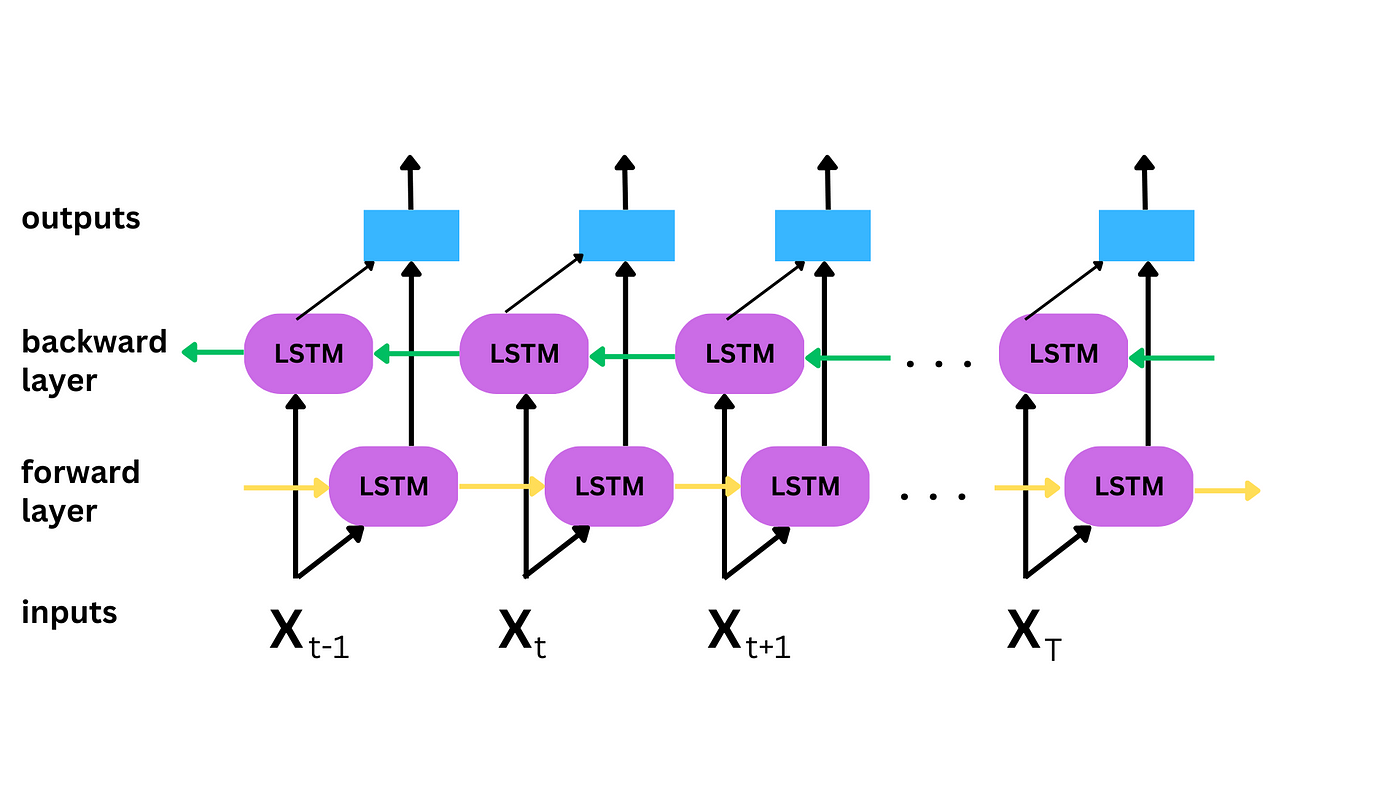
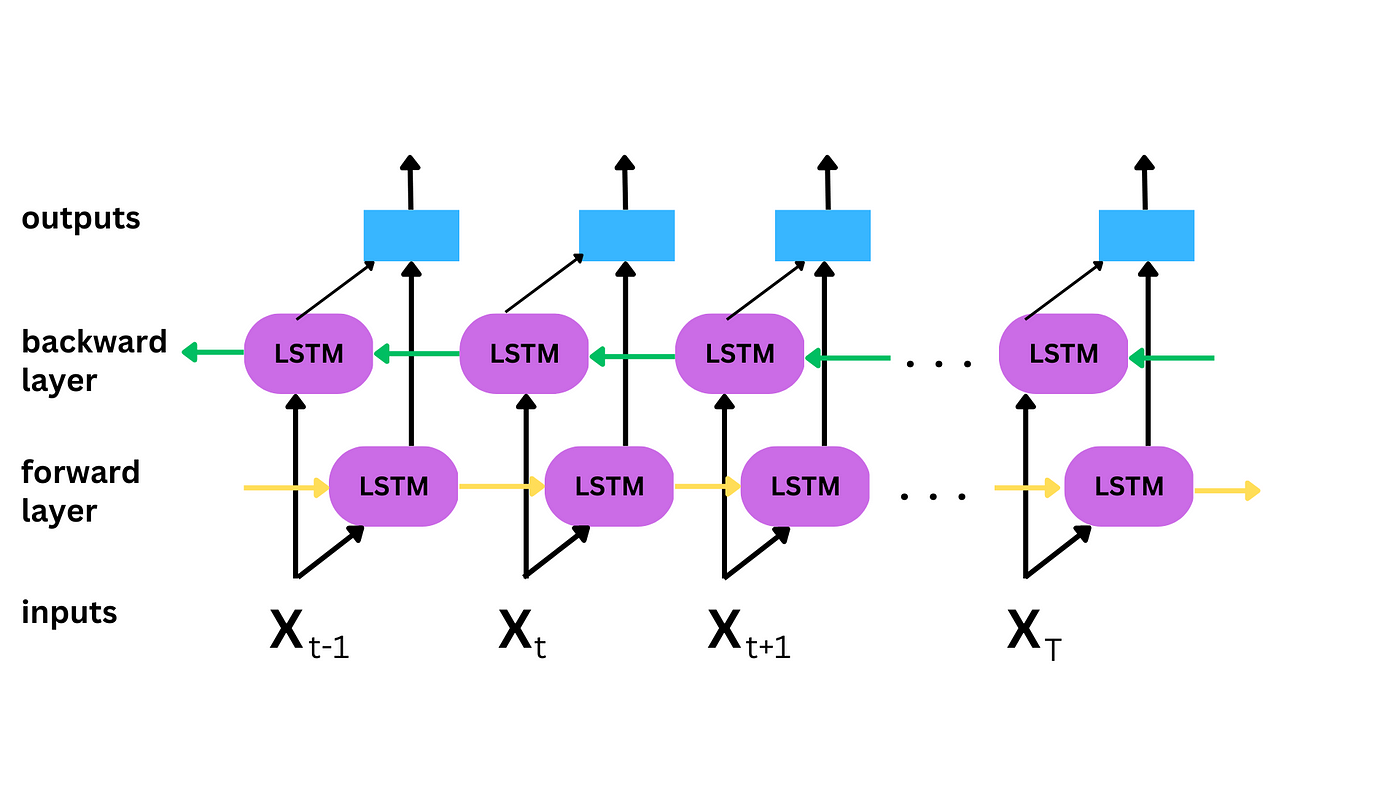

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
import plotly.graph_objects as go

# Define experiment name
EXPERIMENT = "bilstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test"
experiment_name = datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_" + EXPERIMENT

print(f"We are performing: {experiment_name}")

# Define optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Define the model
model = Sequential()

# Input layer (shape should match train_x dimensions)
model.add(InputLayer(input_shape=(train_x.shape[1],1)))

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, activation="selu", return_sequences=False)))

# Dense layers for further learning and transformations
model.add(Dense(256, activation="selu"))
model.add(Dense(128, activation="selu"))
model.add(Dense(64, activation="selu"))

# Output layer
model.add(Dense(1, activation="linear"))

# Print model summary to check architecture
model.summary()

# Compile the model
model.compile(
    optimizer=opt,
    loss="huber",
    metrics=["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

# Define early stopping and model checkpoint callbacks
es = EarlyStopping(monitor="val_loss", patience=50)
mc = ModelCheckpoint(
   "/kaggle/working/Results/trained_model/%s_best.keras" % experiment_name,
    save_best_only=True,
    monitor="val_loss",
)

In [ ]:
%%time
history = model.fit(train_x, train_y,
                   epochs = 120,
                   batch_size = 32,
                   verbose = 1,
                   validation_split = 0.2,
                    callbacks = [mc, es]
                   )

In [ ]:
EXPERIMENT = "bilstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test"
experiment_name = datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_" + EXPERIMENT
experiment_name # replace with actual experiment name

# save the model
model_path = "/kaggle/working/results/trained_model/{}_model.h5".format(experiment_name)
model.save(model_path)

In [ ]:
model.evaluate(test_x, test_y)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert history to DataFrame
df = pd.DataFrame(history.history)

# Add an epoch column
df['epoch'] = df.index

# Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars=['epoch'], value_vars=['loss', 'val_loss'], var_name='Type', value_name='Loss')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='epoch', y='Loss', hue='Type')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history.history' is from a Keras model training
plt.figure(figsize=(10, 6))
plt.plot(history.history["rmse"], label="Train RMSE")
plt.plot(history.history["val_rmse"], label="Validation RMSE", color='r')
plt.title("RMSE Trend")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_predictions = model.predict(train_x)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cycle_num = 0
steps_num = len(train_y)  # fix here
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)

predicted_soc = train_predictions.flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num]
actual_soc = train_y.to_numpy().flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(step_index, predicted_soc, label="SoC Predicted")
plt.plot(step_index, actual_soc, label="SoC Actual", color='r')
plt.title("Results on Training")
plt.xlabel("Step")
plt.ylabel("SoC Percentage")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(step_index, actual_soc, label="SoC Actual", color='r')
plt.title("Results on Training")
plt.xlabel("Step")
plt.ylabel("SoC Percentage")
plt.legend()
plt.grid(True)
plt.show()
# Plot
plt.figure(figsize=(12, 6))
plt.plot(step_index, predicted_soc, label="SoC Predicted")
plt.title("Results on Training")
plt.xlabel("Step")
plt.ylabel("SoC Percentage")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_predictions = model.predict(test_x)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cycle_num = 0
steps_num = len(test_y)  # fix here
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)

predicted_soc = test_predictions.flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num]
actual_soc = test_y.to_numpy().flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(step_index, predicted_soc, label="SoC Predicted")
plt.plot(step_index, actual_soc, label="SoC Actual", color='r')
plt.title("Results on Test")
plt.xlabel("Step")
plt.ylabel("SoC Percentage")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(step_index, actual_soc, label="SoC Actual", color='r')
plt.title("Results on Test")
plt.xlabel("Step")
plt.ylabel("SoC Percentage")
plt.legend()
plt.grid(True)
plt.show()
# Plot
plt.figure(figsize=(12, 6))
plt.plot(step_index, predicted_soc, label="SoC Predicted")
plt.title("Results on Test")
plt.xlabel("Step")
plt.ylabel("SoC Percentage")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00003.csv")
df = pd.DataFrame (data)
print (df.head())

# BASIC 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
#df['SoC'] = (df['Voltage_measured'] / df['Voltage_measured'].max())
df['SoC'] = (df['Voltage_measured'] / 4.2)*100

print (df.head())
# Split features and target
#this is the target SoC
target = df['SoC']
#these are the features 
features = df[['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time' , 'Current_charge']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
#df['SoC'] = (df['Voltage_measured'] / df['Voltage_measured'].max())
df['SoC'] = (df['Voltage_measured'] / 4.2)*100

print (df.head())
# Split features and target
#this is the target SoC
target = df['SoC']
#these are the features 
features = df[['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time' , 'Current_charge']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## LINEAR REGRESSION

#### What is linear regression?
Linear regression analysis is used to predict the value of a variable based on the value of another variable. The variable you want to predict is called the dependent variable. The variable you are using to predict the other variable's value is called the independent variable.
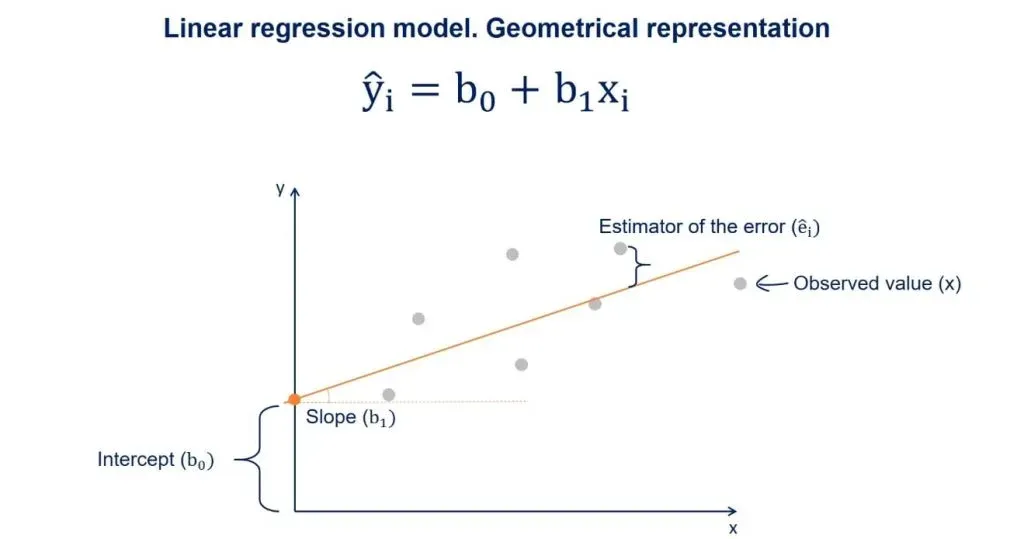
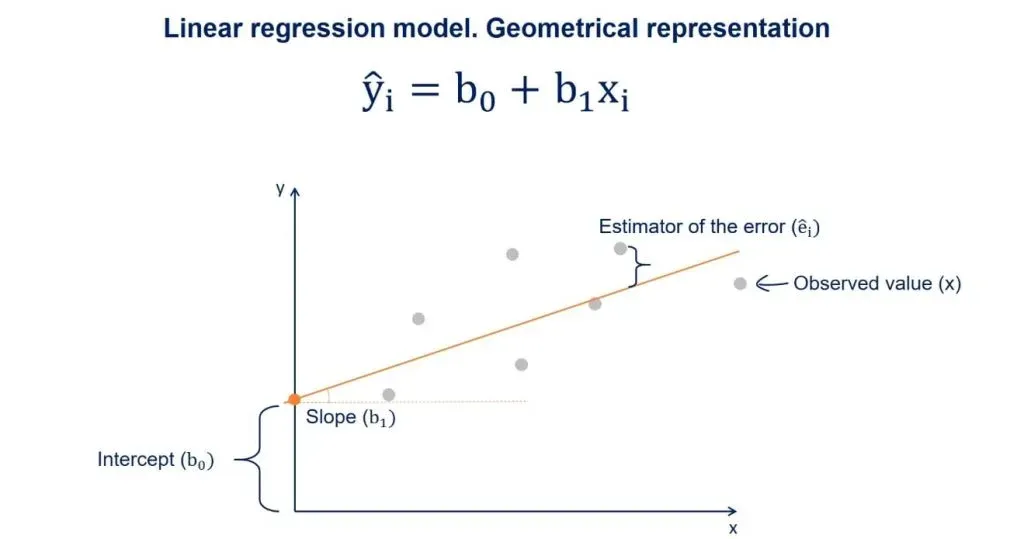

In [ ]:
#let's run the MODEL 
model = LinearRegression()
model.fit(X_train, y_train)
# Make Predictions and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")

In [ ]:

# Plot the true SoC values vs. predicted SoC values
plt.figure(figsize=(10, 6))

# Plotting true SoC values
plt.plot(y_test.values, label="True SoC", marker='o', color='black')

# Plotting predicted SoC values
plt.plot(y_pred, label="Predicted SoC", marker='x', color='y')

# Adding labels and title
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC vs Predicted SoC")
plt.legend()
plt.show()


In [ ]:
# Plotting true SoC values
plt.plot(y_test.values, label="True SoC", marker='x', color='r')
# plt.plot(y_test.values, label="True SoC", marker='o', color='black')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC")
plt.legend()
plt.show()
plt.plot(y_pred, label="Predicted SoC", marker='x', color='y')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("Predicted SoC")
plt.legend()
plt.show()


## Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


In [ ]:
# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print(f"Mean Absolute Error (Random Forest): {mae_rf}")
print(f"Root Mean Square Error (Random Forest): {rmse_rf}")

In [ ]:

# Plotting true SoC vs predicted SoC for the Random Forest model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True SoC", marker='o', linestyle='-', color='b')
plt.plot(y_pred_rf, label="Predicted SoC (Random Forest)", marker='x', linestyle='--', color='r')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC vs Predicted SoC - Random Forest")
plt.legend()
plt.show()

In [ ]:
plt.plot(y_test.values, label="True SoC", marker='o', linestyle='-', color='y')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC")
plt.legend()
plt.show()
plt.plot(y_pred_rf, label="Predicted SoC (Random Forest)", marker='x', linestyle='--', color='r')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("Predicted SoC - Random Forest")
plt.legend()
plt.show()

## Using LSTM MODEL 

#### Long Short-Term Memory (LSTM)
A Long short-term memory (LSTM) is a type of Recurrent Neural Network specially designed to prevent the neural network output for a given input from either decaying or exploding as it cycles through the feedback loops. The feedback loops are what allow recurrent networks to be better at pattern recognition than other neural networks. Memory of past input is critical for solving sequence learning tasks and Long short-term memory networks provide better performance compared to other RNN architectures by alleviating what is called the vanishing gradient problem.

LSTMs due to their ability to learn long term dependencies are applicable to a number of sequence learning problems including language modeling and translation, acoustic modeling of speech, speech synthesis,speech recognition, audio and video data analysis, handwriting recognition and generation, sequence prediction, and protein secondary structure prediction.

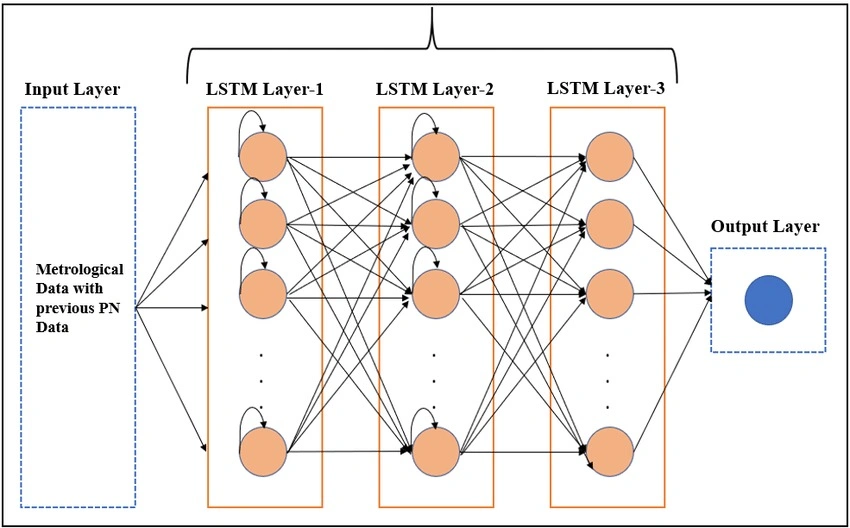
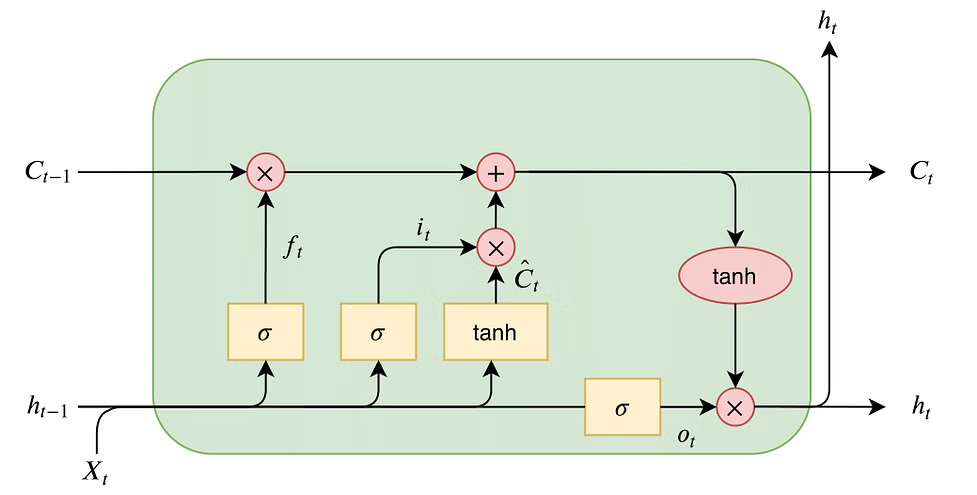
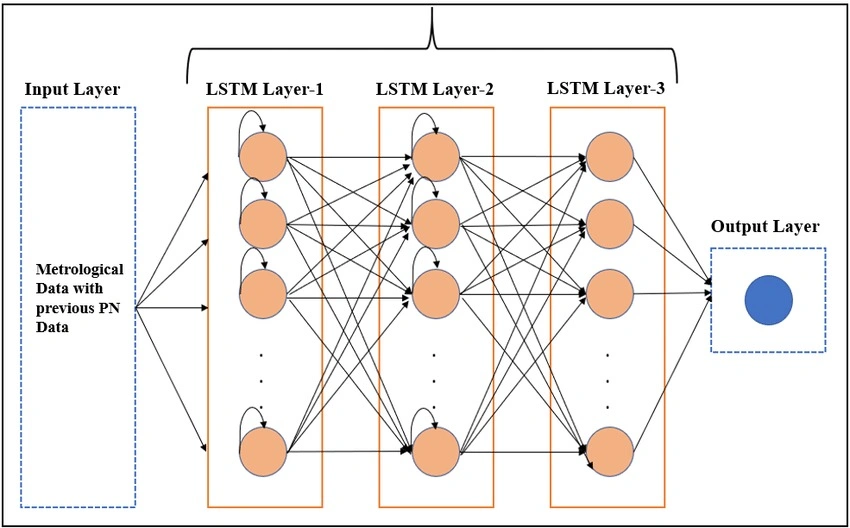
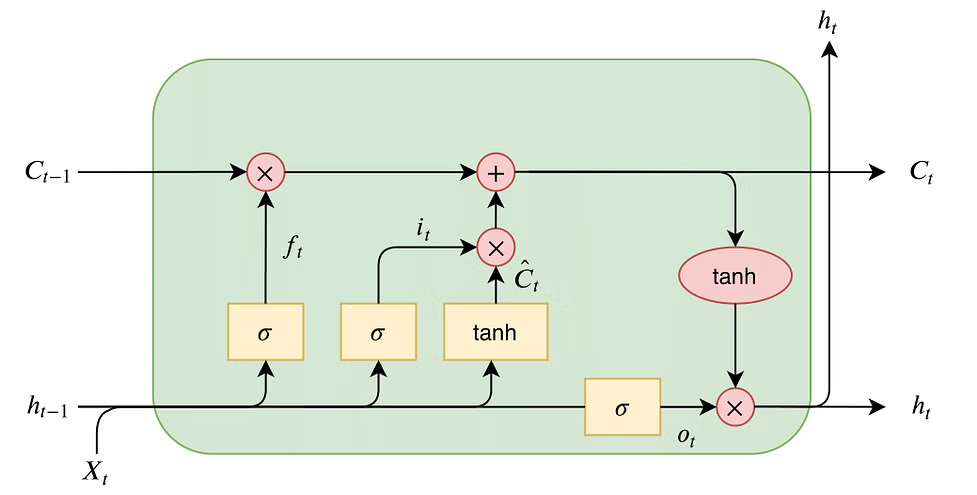

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Data Preparation
# Scale the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df[['Voltage_measured', 'Current_measured', 
                                             'Temperature_measured', 'Time']])

# Create sequences for LSTM
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps
time_steps = 5  # You can adjust this based on your data
X, y = create_sequences(features_scaled, df['SoC'].values, time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Step 2: Define the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output layer for SoC prediction
model.compile(optimizer='adam', loss='mse')

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Step 4: Make Predictions and Evaluate
y_pred_lstm = model.predict(X_test)

# You might want to inverse scale your predictions if you used MinMaxScaler
# y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Evaluate the model
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = mean_squared_error(y_test, y_pred_lstm, squared=False)

print(f"Mean Absolute Error (LSTM): {mae_lstm}")
print(f"Root Mean Square Error (LSTM): {rmse_lstm}")


In [ ]:

# Plotting true SoC vs predicted SoC for the LSTM model
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True SoC", marker='o', linestyle='-', color='black')
plt.plot(y_pred_lstm, label="Predicted SoC (LSTM)", marker='x', linestyle='--', color='purple')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC vs Predicted SoC - LSTM")
plt.legend()
plt.show()


In [ ]:
plt.plot(y_test, label="True SoC", marker='o', linestyle='-', color='y')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC vs Predicted SoC - LSTM")
plt.legend()
plt.show()
plt.plot(y_pred_lstm, label="Predicted SoC (LSTM)", marker='x', linestyle='--', color='purple')
plt.xlabel("Sample")
plt.ylabel("SoC")
plt.title("True SoC vs Predicted SoC - LSTM")
plt.legend()
plt.show()

# PREDICTING SOH BASED ON SOC 

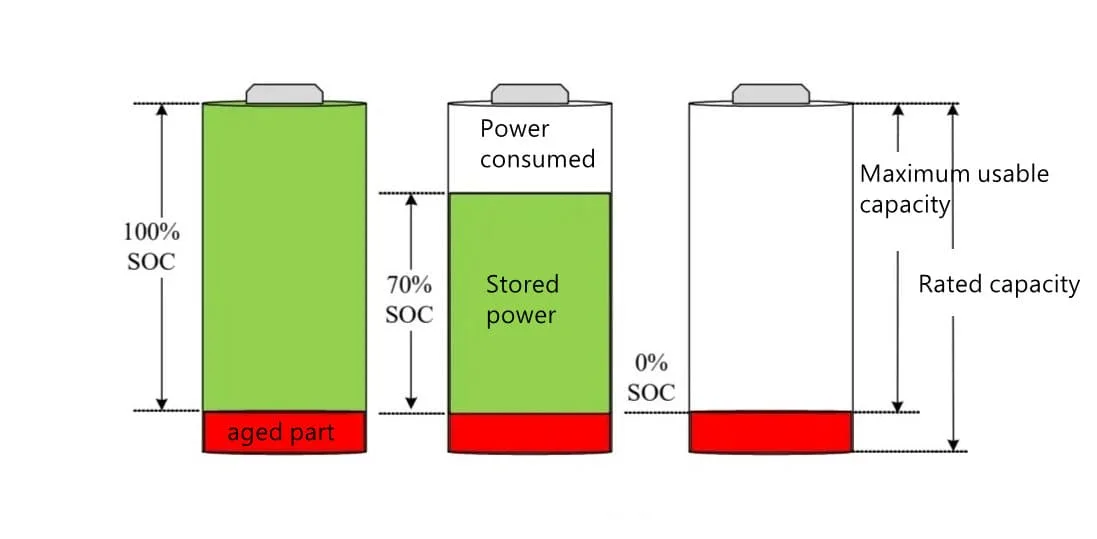
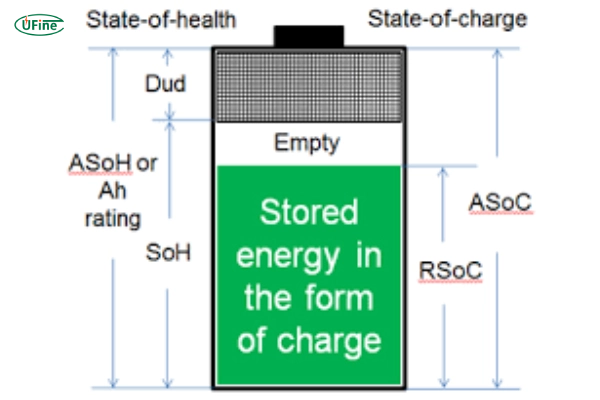

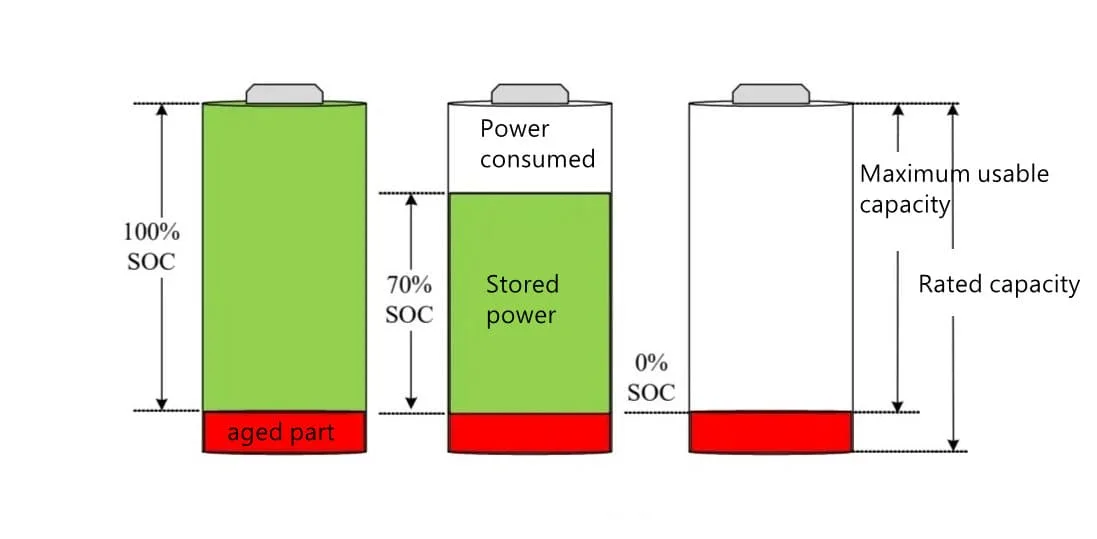
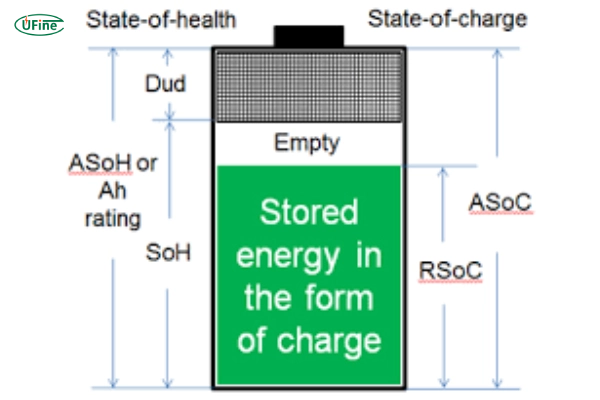

In [ ]:
metadata_df = pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv")
metadata_df

## SOH Calculation
The formula is: SOH = (Current Maximum Capacity / Original Rated Capacity). 

Here's a more detailed breakdown:
1. Determine the Original Rated Capacity:
This is the capacity the battery was designed to hold when new, typically specified in Ampere-hours (Ah) or Watt-hours (Wh). 
2. Measure the Current Maximum Capacity:
This requires a controlled discharge test or measurement under specific conditions to determine the actual remaining capacity of the battery at its current state. 
3. Calculate the SOH:
Divide the current maximum capacity by the original rated capacity and multiply by 100% to express the SOH as a percentage. 
Example:
If a battery was originally rated for 100 Ah and after some use, its maximum capacity is measured to be 80 Ah, the SOH would be: (80 Ah / 100 Ah) * 100% = 80%. 

In [ ]:
capacity = metadata_df[metadata_df['battery_id']=='B0055'][metadata_df['type']=='discharge']
SOH_series = pd.to_numeric(capacity['Capacity'], errors='coerce')/ 1.6579955793677608
# capacity_series = capacity['Capacity']/ 1.6579955793677608
cycles = range(1,len(SOH_series)+1)
capacity_df = pd.DataFrame(columns = ['SOH', 'cycle'])
capacity_df['SOH'] = SOH_series
capacity_df['cycle'] = cycles
capacity_df

In [ ]:
plt.scatter(capacity_df['cycle'], capacity_df['SOH'])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 2  # Number of past time steps to consider
X, y = create_sequences(cycles, seq_length)
num_features = 1
y = capacity_df['SOH'][seq_length:]
X_train, X_test, y_train, y_test = train_test_split(X[:35], y[:35], test_size=0.2, random_state=42)

In [ ]:
y[:30]

## Using GRU Neural Network

#### What is Gated Recurrent Unit(GRU) ?
GRU stands for Gated Recurrent Unit, which is a type of recurrent neural network (RNN) architecture that is similar to LSTM (Long Short-Term Memory).
#### How GRU Works?
Like other recurrent neural network architectures, GRU processes sequential data one element at a time, updating its hidden state based on the current input and the previous hidden state. At each time step, the GRU computes a “candidate activation vector” that combines information from the input and the previous hidden state. This candidate vector is then used to update the hidden state for the next time step.

### Here’s the math behind the GRU architecture:

The reset gate r and update gate z are computed using the current input x and the previous hidden state h_t-1

r_t = sigmoid(W_r * [h_t-1, x_t])

z_t = sigmoid(W_z * [h_t-1, x_t])

where W_r and W_z are weight matrices that are learned during training.

2. The candidate activation vector h_t~ is computed using the current input x and a modified version of the previous hidden state that is "reset" by the reset gate:

h_t~ = tanh(W_h * [r_t * h_t-1, x_t])

where W_h is another weight matrix.

3. The new hidden state h_t is computed by combining the candidate activation vector with the previous hidden state, weighted by the update gate:

h_t = (1 - z_t) * h_t-1 + z_t * h_t~

Overall, the reset gate determines how much of the previous hidden state to remember or forget, while the update gate determines how much of the candidate activation vector to incorporate into the new hidden state. The result is a compact architecture that is able to selectively update its hidden state based on the input and previous hidden state, without the need for a separate memory cell state like in LSTM.

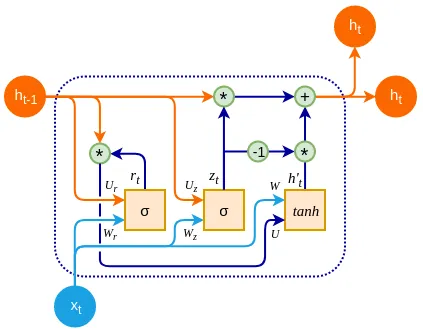!

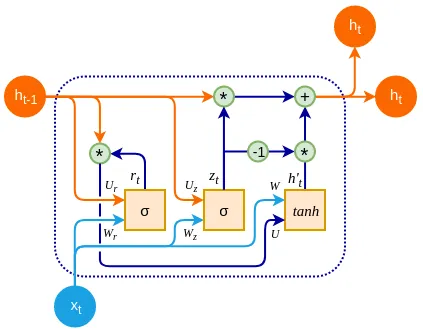

In [ ]:
model_GRU = Sequential()
model_GRU.add(GRU(units=20, return_sequences=True, input_shape=(seq_length, num_features)))
model_GRU.add(GRU(units=50, activation='relu'))
model_GRU.add(Dense(units=1))

In [ ]:
import time
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# Start timer
start_time = time.time()
history = model_GRU.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test))
# End timer
end_time = time.time()

# Calculate the training duration
training_duration_GRU = end_time - start_time
print(f"Training time: {training_duration_GRU:.2f} seconds")

In [ ]:
loss = model_GRU.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

In [ ]:
predictions_GRU = model_GRU.predict(X)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
# import numpy as np

# Assuming y_test_actual contains the true values, and predictions contains the model predictions
mae_GRU = mean_absolute_error(y, predictions_GRU)
mse_GRU = mean_squared_error(y, predictions_GRU)
rmse_GRU = np.sqrt(mse_GRU)
mape_GRU = mean_absolute_percentage_error(y, predictions_GRU) * 100  # Convert to percentage
r2_GRU = r2_score(y, predictions_GRU)

print(f'Mean Absolute Error (MAE): {mae_GRU}')
print(f'Mean Squared Error (MSE): {mse_GRU}')
print(f'Root Mean Squared Error (RMSE): {rmse_GRU}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_GRU}%')
print(f'R-squared (R²): {r2_GRU}')

In [ ]:
residuals_GRU = y_test - predictions_GRU[0]

# plt.figure(figsize=(10, 6))
plt.scatter(capacity_df['cycle'][2:], predictions_GRU)
plt.scatter(capacity_df['cycle'][2:], y, color='r')
plt.show()

## Using Random Forest Algorithum

#### What is random forest?
Random forest is a commonly-used machine learning algorithm, trademarked by Leo Breiman and Adele Cutler, that combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.

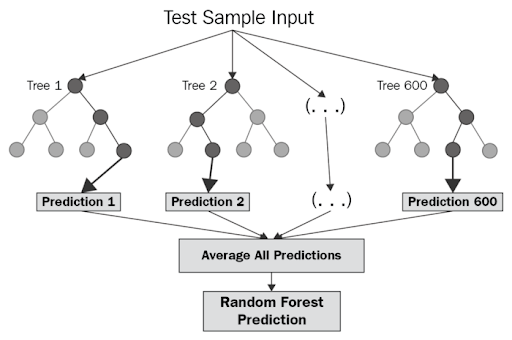
#### Ensemble methods
Ensemble learning methods are made up of a set of classifiers—e.g. decision trees—and their predictions are aggregated to identify the most popular result. The most well-known ensemble methods are bagging, also known as bootstrap aggregation, and boosting. 

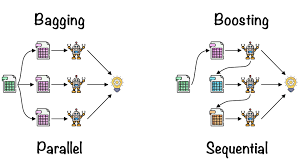
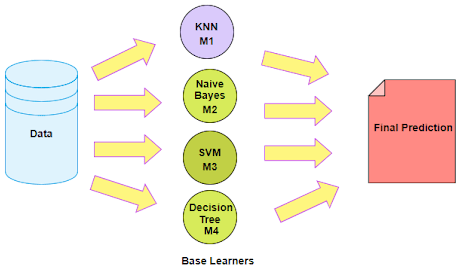

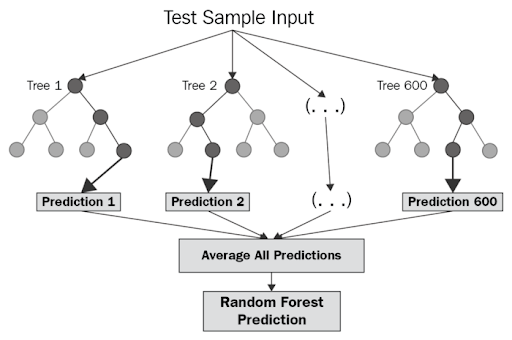
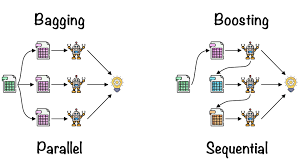
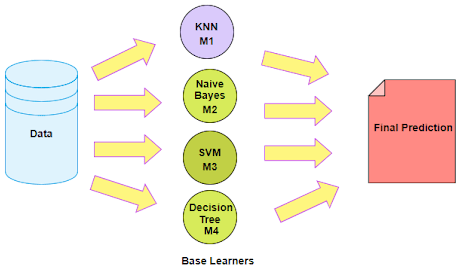

In [ ]:
from sklearn.ensemble import RandomForestRegressor


model_RF = RandomForestRegressor(random_state=0)
# Start timer
start_time = time.time()
model_RF.fit(X_train, y_train)
# End timer
end_time = time.time()

# Calculate the training duration
training_duration_RF = end_time - start_time
print(f"Training time: {training_duration_RF:.2f} seconds")

predictions_RF = model_RF.predict(X)
# preds = model_RF.predict(X_test)
mae_RF = mean_absolute_error(y, predictions_RF)
r2_RF = r2_score(y, predictions_RF)
print(f"MAE: {mae_RF}")
print(f"R2S: {r2_RF}")

# # get feature importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# # Print the feature ranking
# print("Feature ranking:")
# for f in range(X_train.shape[1]):
#     print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")

# plot test_y, preds
# plt.figure(figsize=(10, 6))
plt.scatter(capacity_df['cycle'][2:], predictions_RF)
plt.scatter(capacity_df['cycle'][2:], y, color='r')
plt.show()
# plt.savefig("rul_nasa.png")

## Using XG Boost

#### What is XG Boost
 XGBoost is short for extreme gradient boosting. This method is based on decision trees and improves on other methods such as random forest and gradient boost. It works well with large, complicated datasets by using various optimization methods.

To fit a training dataset using XGBoost, an initial prediction is made. Residuals are computed based on the predicted value and the observed values. A decision tree is created with the residuals using a similarity score for residuals. The similarity of the data in a leaf is calculated, as well as the gain in similarity in the subsequent split. The gains are compared to determine a feature and a threshold for a node. The output value for each leaf is also calculated using the residuals. For classification, the values are typically calculated using the log of odds and probabilities. The output of the tree becomes the new residual for the dataset, which is used to construct another tree. This process is repeated until the residuals stop reducing or for a specified number of times. Each subsequent tree learns from the previous trees and is not assigned equal weight, unlike how Random Forest works.
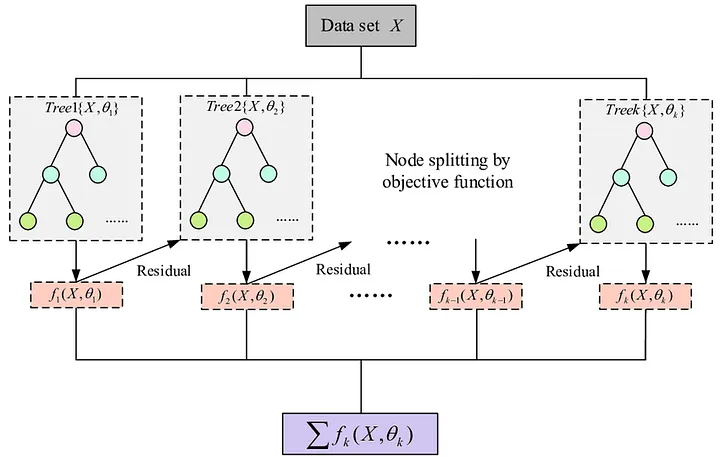

#### What is the difference between XG Boost and Random Forest? Explaining Boosting and Bagging.
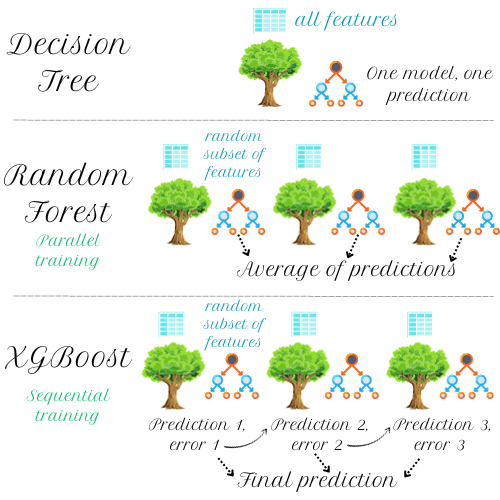

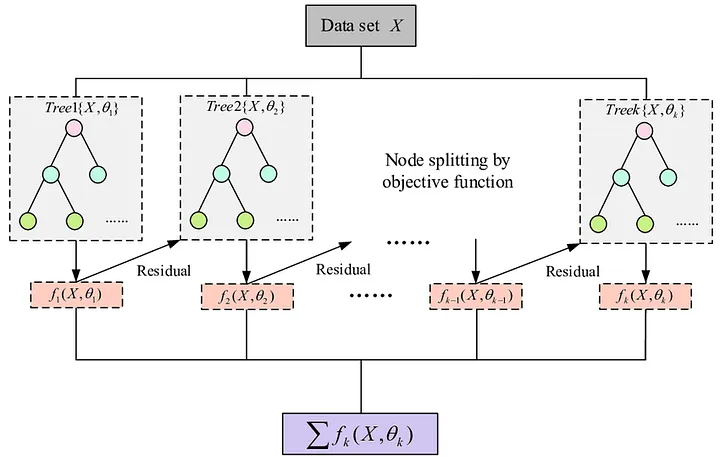
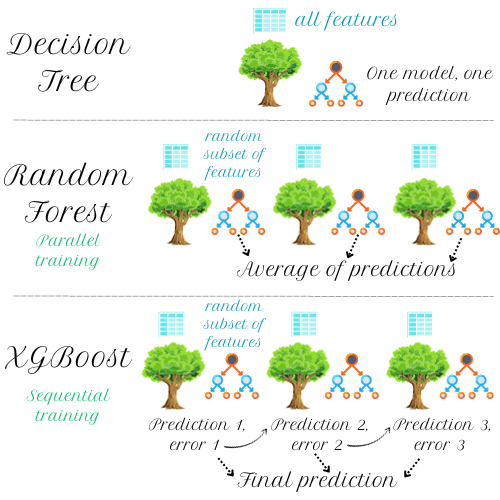

In [ ]:
from xgboost import XGBRegressor

# Instantiate XGBoost model
model_XG = XGBRegressor(random_state=0)

# Start timer
start_time = time.time()
# Fit model
model_XG.fit(X_train, y_train)
# End timer
end_time = time.time()

# Calculate the training duration
training_duration_XG = end_time - start_time
print(f"Training time: {training_duration_XG:.2f} seconds")


# Predictions
predictions_XG = model_XG.predict(X)

# Evaluation
mae_XG = mean_absolute_error(y, predictions_XG)
r2_XG = r2_score(y, predictions_XG)
print(f"MAE: {mae_XG}")
print(f"R2S: {r2_XG}")

# # Feature importance
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]
# print("Feature ranking:")
# for f in range(train_X.shape[1]):
#     print(f"{train_X.columns[indices[f]]}: {importances[indices[f]]}")

# # Plotting test_y vs. preds
# plt.scatter(test_y, preds)
# plt.plot(test_y, test_y)
# plt.show()  # Display the plot
# plt.savefig("rul_nasa.png")
# plt.figure(figsize=(10, 6))

plt.scatter(capacity_df['cycle'][2:], predictions_XG)
plt.scatter(capacity_df['cycle'][2:], y,color='r')
plt.show()

In [ ]:
print(f"Training time for GRU: {training_duration_GRU:.2f} seconds")
print(f"Training time for RF: {training_duration_RF:.2f} seconds")
print(f"Training time for XG: {training_duration_XG:.2f} seconds")
print(f"MAE for GRU: {mae_GRU}")
print(f"MAE for FR: {mae_RF}")
print(f"MAE for XG: {mae_XG}")
print(f"R2 for GRU: {r2_GRU}")
print(f"R2 for RF: {r2_RF}")
print(f"R2 for XG: {r2_XG}")